# Medical Insurance Cost Prediction
This project predicts medical insurance charges using a Random Forest model built with a full preprocessing+training pipeline.


# Getting the Data



In [ ]:
import kagglehub
import pandas as pd
import os
# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'insurance' dataset.
Path to dataset files: /kaggle/input/insurance


In [ ]:

# File name: "insurance.csv"
csv_path = os.path.join(path, "insurance.csv")

patients = pd.read_csv(csv_path)

# Taking a Quick Look at the Data Structure

In [ ]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
patients.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
patients.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


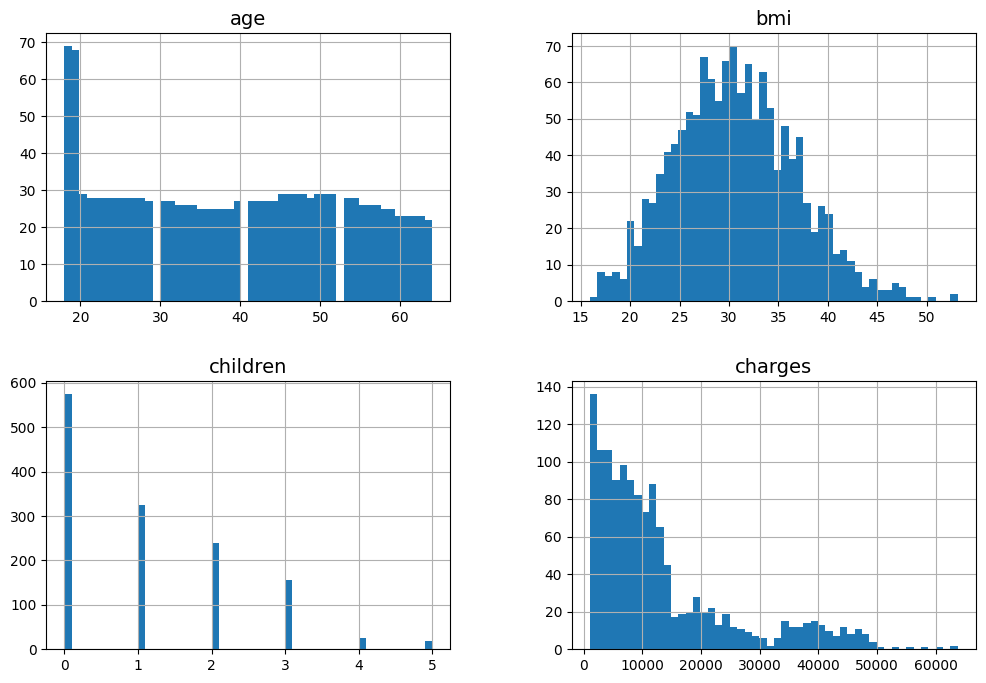

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

patients.hist(bins=50, figsize=(12, 8))

plt.show()

## Creating a Stratified Train/Test Split

The "smoker" variable has an imbalanced distribution.
A normal random train_test_split may produce a test set  that does not preserve the real smoker proportion.
To illustrate this, we compute the probability that a
purely random split produces a biased sample.



In [ ]:
import numpy as np
from scipy.stats import binom

total_rows = len(patients)
total_smokers = patients["smoker"].value_counts()["yes"]
p_real = total_smokers / total_rows

# Test set size (20%)
n_test = int(total_rows * 0.2)

print(f"--- Parameters ---")
print(f"Population size (N): {total_rows}")
print(f"True smoker proportion (p): {p_real:.4f}")
print(f"Test set size (n): {n_test}")
print(f"Expected number of smokers in Test (mean): {n_test * p_real:.1f}")

# We define an acceptable deviation tolerance (e.g., ±3% from the true population rate)
tolerance = 0.03

limit_low_pct = p_real - tolerance
limit_high_pct = p_real + tolerance

# Convert percentages to actual counts
# Fails if X <= k_low OR X > k_high
k_low = int(n_test * limit_low_pct)
k_high = int(n_test * limit_high_pct)

print(f"Acceptable smoker count range: between {k_low} and {k_high}.")
print(f"Sampling is considered 'bad' if there are fewer than {k_low} or more than {k_high} smokers.")

# Probability of sampling too few smokers (left tail)
prob_too_few = binom.cdf(k_low - 1, n_test, p_real)

# Probability of sampling too many smokers (right tail)
prob_too_many = 1 - binom.cdf(k_high, n_test, p_real)

total_fail_probability = prob_too_few + prob_too_many

print(f"Probability that random sampling fails: {total_fail_probability:.4f}")
print(f"In other words: {total_fail_probability * 100:.2f}%")

--- Parameters ---
Population size (N): 1070
True smoker proportion (p): 0.2047
Test set size (n): 214
Expected number of smokers in Test (mean): 43.8
Acceptable smoker count range: between 37 and 50.
Sampling is considered 'bad' if there are fewer than 37 or more than 50 smokers.
Probability that random sampling fails: 0.2352
In other words: 23.52%


This roughly 20% probability indicates that, if you perform an unstratified random train_test_split, one in five splits will produce a test set with a substantially biased smoker proportion (i.e., the test set will not reflect the population distribution)..

In [ ]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    patients,
    test_size=0.2,
    stratify=patients["smoker"],  # <--- Here its the stratify
    random_state=42
)

In [ ]:
strat_test_set["smoker"].value_counts() / len(strat_test_set)

,count
smoker,
no,0.794776
yes,0.205224


In [ ]:
def income_cat_proportions(data):
    return data["smoker"].value_counts() / len(data)

train_set, test_set = train_test_split(patients, test_size=0.2,
                                       random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(patients),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
no,79.52,79.48,79.85,-0.06,0.41
yes,20.48,20.52,20.15,0.22,-1.61


# Discovering and Visualizing the Data to Gain Insights


In [ ]:
patients_eda = strat_train_set.copy()

## Looking for Correlations

In [ ]:
patients_eda["smoker_code"] = patients_eda["smoker"].map({"yes": 1, "no": 0})
patients_eda["sex_code"] = patients_eda["sex"].map({"male": 1, "female": 0})

corr_matrix = patients_eda.corr(numeric_only=True)


corr_matrix["charges"].sort_values(ascending=False)

,charges
charges,1.000000
bmi_smoker,0.841228
obese_smoker,0.814959
smoker_code,0.782336
age,0.291370
bmi,0.185565
is_obese,0.181008
children,0.061811
sex_code,0.039383


These engineered features were initially explored for use with linear models, but the final model is a RandomForestRegressor, which naturally captures nonlinear interactions. Because of that, manually engineered interaction terms were not required and were excluded from the final pipeline to keep it clean and interpretable.


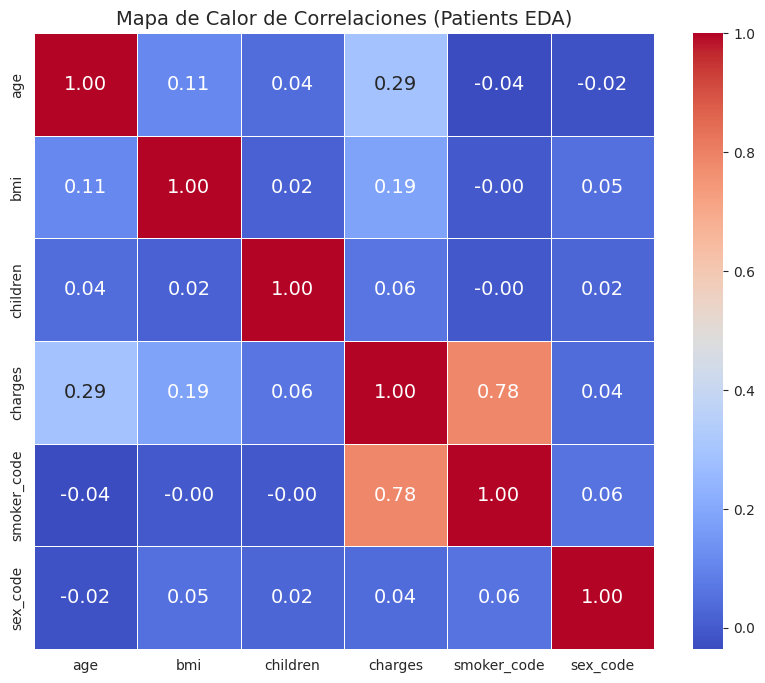

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Mapa de Calor de Correlaciones (Patients EDA)")
plt.show()

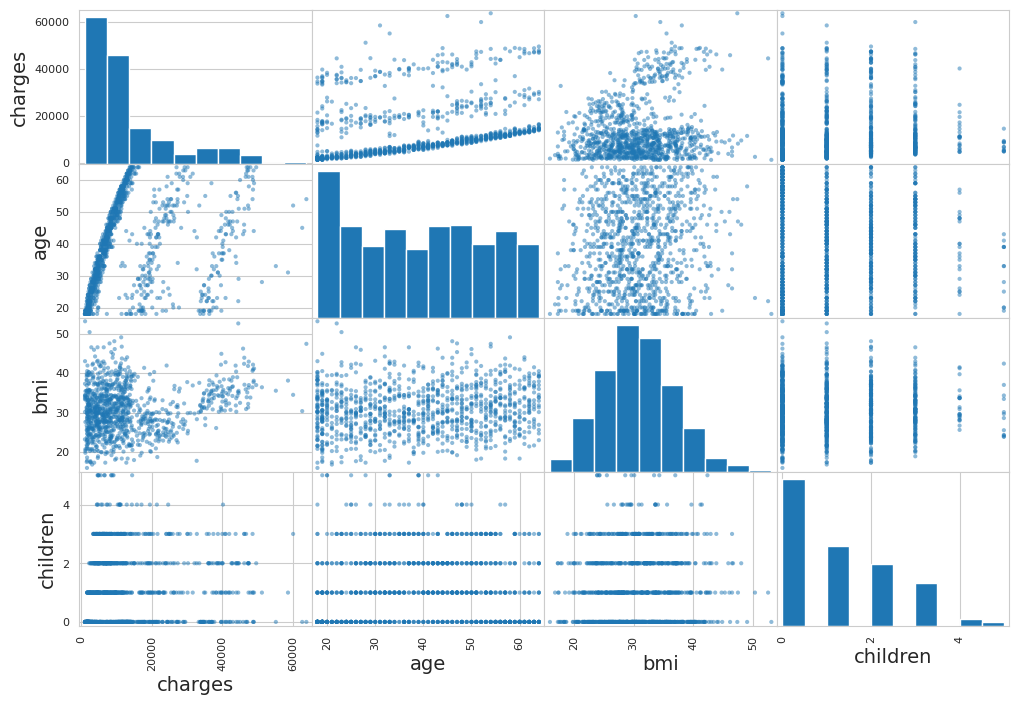

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi", "children"]
scatter_matrix(patients_eda[attributes], figsize=(12, 8))
plt.show()

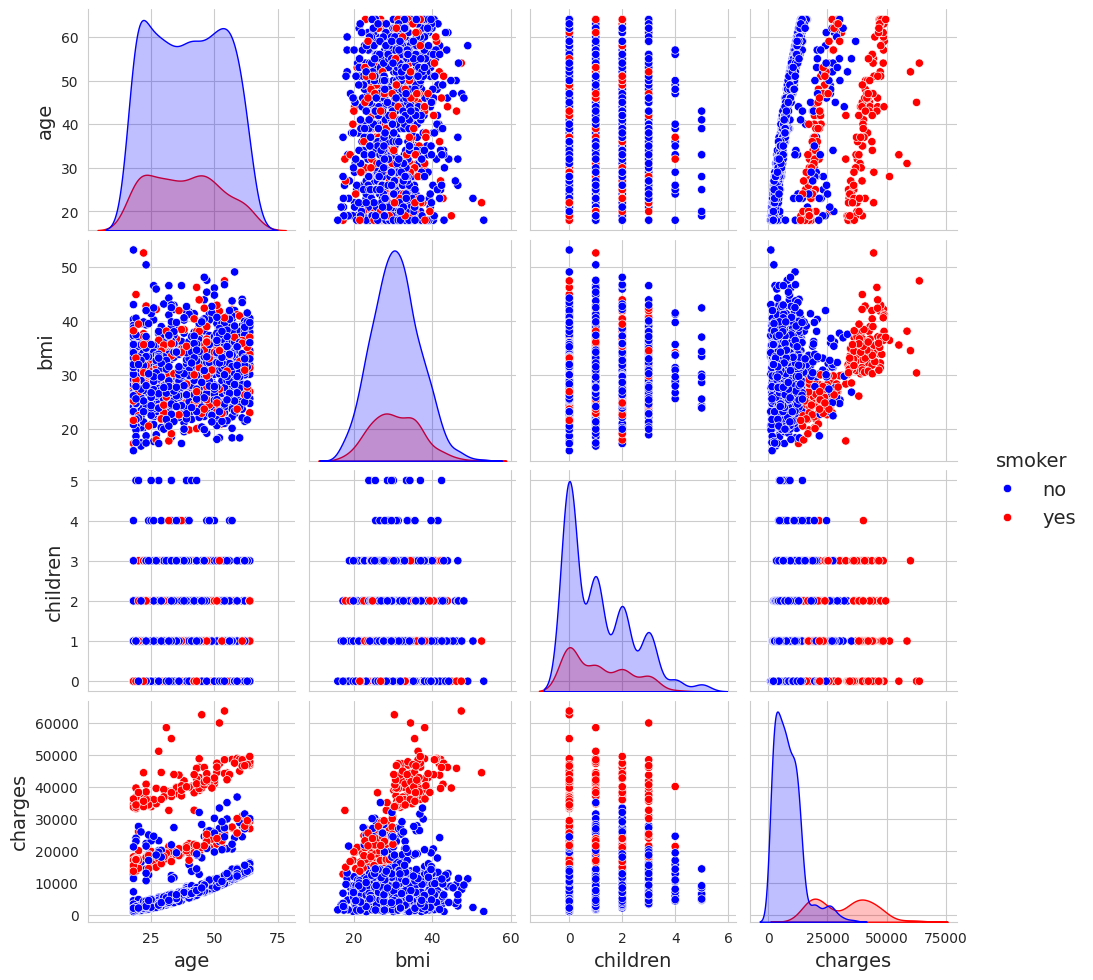

In [ ]:
import seaborn as sns

# hue="smoker"
sns.pairplot(
    patients_eda[["age", "bmi", "children", "charges", "smoker"]],
    hue="smoker",
    palette=["blue", "red"],
    height=2.5
)
plt.show()

Mas relevantes:
Age - Charges
Charges- Bmi



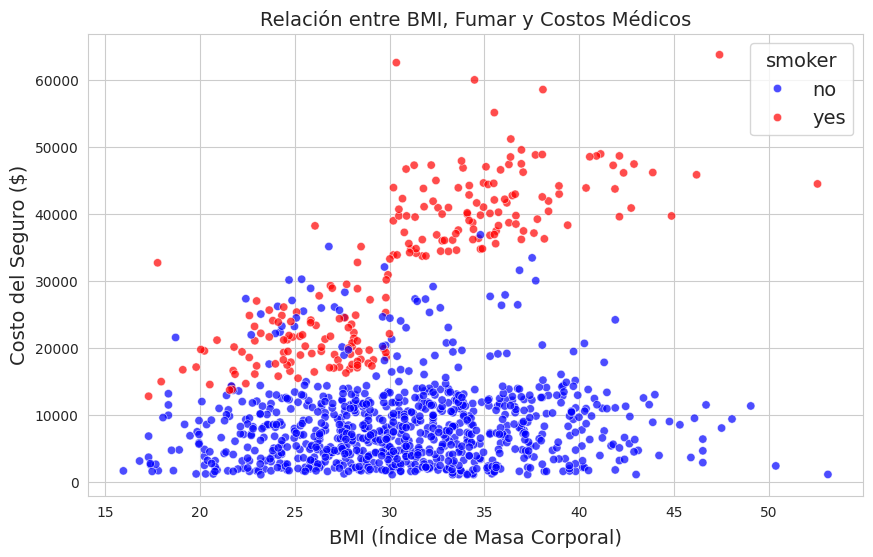

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Scatterplot: BMI vs Costos,
sns.scatterplot(
    data=patients_eda,
    x="bmi",
    y="charges",
    hue="smoker",
    alpha=0.7,
    palette=["blue", "red"]
)

plt.title("Relación entre BMI, Fumar y Costos Médicos", fontsize=14)
plt.xlabel("BMI (Índice de Masa Corporal)")
plt.ylabel("Costo del Seguro ($)")
plt.show()

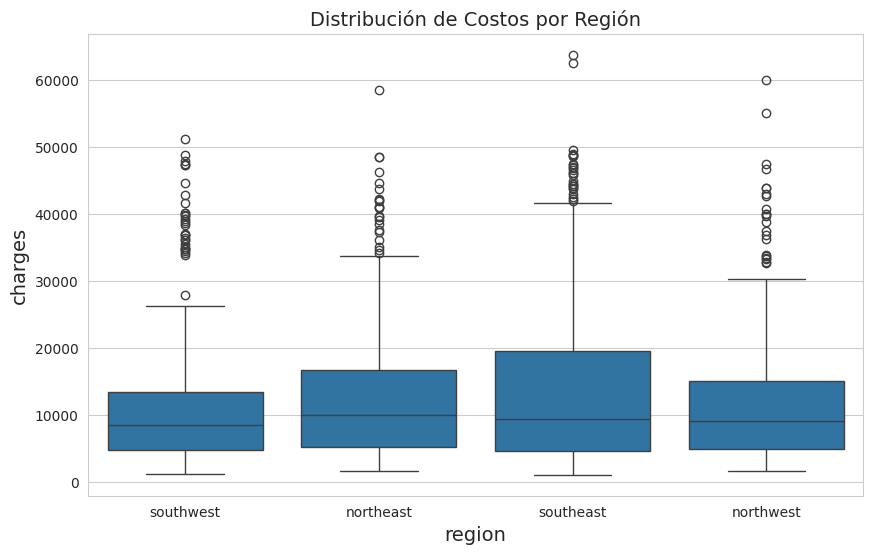

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=patients_eda, x="region", y="charges")

plt.title("Distribución de Costos por Región")
plt.show()

## Experimenting with Attribute Combinations


In [ ]:
patients_eda["bmi_smoker"] = patients_eda["bmi"] * patients_eda["smoker_code"]
patients_eda["is_obese"] = (patients_eda["bmi"] >= 30).astype(int)
patients_eda["obese_smoker"] = patients_eda["is_obese"] * patients_eda["smoker_code"]

corr_matrix = patients_eda.corr(numeric_only=True)

corr_matrix["charges"].sort_values(ascending=False)

,charges
charges,1.000000
bmi_smoker,0.841228
obese_smoker,0.814959
smoker_code,0.782336
age,0.291370
bmi,0.185565
is_obese,0.181008
children,0.061811
sex_code,0.039383


# Prepare the Data for Machine Learning Algorithms

In [ ]:
patients.head()

,age,sex,bmi,children,smoker,region
294,25,male,26.800,3,no,southwest
179,41,female,33.155,3,no,northeast
1335,18,female,36.850,0,no,southeast
634,51,male,39.700,1,no,southwest
67,40,male,26.315,1,no,northwest


In [ ]:
patients = strat_train_set.drop("charges", axis=1)
patients_labels = strat_train_set["charges"].copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

#Preprocessing setup (numeric + categorical pipelines)

# Numeric features: impute missing values and scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Categorical features: one-hot encode, safely ignoring unseen categories
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])


# Combine both pipelines using a column transformer
preprocessing = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
])



# Full pipeline (preprocessing + model)

base_model = RandomForestRegressor(random_state=42)

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', base_model)
])


#Apply log transform to the target (helps with skewed data(in this case "charges"))
log_pipeline = TransformedTargetRegressor(
    regressor=full_pipeline,
    func=np.log1p,       # log(1 + y)
    inverse_func=np.expm1  # exp(y) - 1
)



# Hyperparameter tuning using GridSearchCV
param_grid = {
    'regressor__model__n_estimators': [30, 100, 200],
    'regressor__model__max_features': [2, 4, 6],
    'regressor__model__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(
    estimator=log_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(patients, patients_labels)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_


# Final evaluation on the test set
X_test = strat_test_set.drop("charges", axis=1)
y_test = strat_test_set["charges"].copy()

final_predictions = best_model.predict(X_test)

# Fix: Calculate MSE first, then take the square root for RMSE (because im using an old version)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
print(f"\n--- Final result ---")
print(f"RMSE on Test Set: ${rmse:,.2f}")



# Save final model (ready to be used with raw input data)
joblib.dump(best_model, "modelo_seguros_pipeline_v2.pkl")
print("\nModelo guardado como modelo_seguros_pipeline_v2.pkl")

{'regressor__model__max_depth': 10, 'regressor__model__max_features': 6, 'regressor__model__n_estimators': 100}

--- Final result ---
RMSE on Test Set: $4,345.27

Modelo guardado como modelo_seguros_pipeline_v2.pkl


The target variable (charges) has high variance, so RMSE values around $4k are common and expected for this dataset.

In [ ]:
import joblib
import pandas as pd

modelo_cargado = joblib.load("modelo_seguros_pipeline_v2.pkl")

nuevo_paciente = pd.DataFrame([{
    "age": 35,
    "sex": "male",
    "bmi": 45,          # Obeso
    "children": 2,
    "smoker": "yes",    # Fumador (¡Peligro!)
    "region": "southeast"
}])

prediccion = modelo_cargado.predict(nuevo_paciente)

print(f"Costo estimado para este paciente: ${prediccion[0]:,.2f}")

Costo estimado para este paciente: $42,806.54
